In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [184]:
class MarkovChain():
    def __init__(self, M):
        self.M = M
        self.n = M.shape[0]
        self.w = (1/self.n)*(np.ones(self.n)).reshape(1, self.n)
        self.iter = 0
        self.w_hist = []
        self.calc_w_inf()
    
    def calc_w_inf(self):
        eigen_values, eigen_vectors = np.linalg.eig(self.M.T)
        eigen_values = np.real(eigen_values)
        diff_to_1 = np.abs(eigen_values - 1)
        diff_sort = np.argsort(diff_to_1)
        w_inf = eigen_vectors[:,diff_sort][:, 1:2]
        w_inf = w_inf.flatten()
        self.w_inf = w_inf/np.sum(w_inf)
        
    def update(self):
        self.w = self.w.dot(self.M)
        self.iter += 1
    
    def calc_distance(self):
        return np.linalg.norm(self.w_inf - self.w, ord=1)
    
    def run(self, num_of_iters):
        self.l = []
        for i in range(num_of_iters):
            self.update()
            self.w_hist.append(self.w)
            self.l.append(self.calc_distance())
    
    def plot(self):
        sns.set(font_scale=3)
        plt.figure(figsize=(20, 15))
        sns.set_style('whitegrid')
        plt.plot(range(1, self.iter+1), np.log(self.l))
        plt.ylabel('Distance between w and w_inf')
        plt.xlabel('Iterations')
        plt.title('Distance vs. Iterations')
        plt.savefig('1a.png')
        plt.show()
        
    
def display_top_k_teams(scores, team_names, k = 25):
    scores = np.real(scores.flatten())
    sorted_indices = np.argsort(-scores).flatten()
    sorted_teams = [team_names[i] for i in sorted_indices]
    sorted_scores = [scores[i] for i in sorted_indices]
    team_score = ["{:20s} - {:.6f}".format(sorted_teams[i], sorted_scores[i]) for i,j in enumerate(sorted_teams[:k])]
    print("\n".join(team_score))
    
def create_transition_matrix(scores, num_of_teams):
    M = np.zeros((num_of_teams, num_of_teams))
    for i in range(scores.shape[0]):
        team_a_id, team_a_points, team_b_id, team_b_points = tuple(scores[i, :].astype(np.int32))
        a_wins_indicator = 1 if (team_a_points > team_b_points) else 0
        win_points_fraction = (team_a_points/(team_a_points + team_b_points))
        M[team_a_id - 1, team_a_id - 1] += ((a_wins_indicator) + win_points_fraction)
        M[team_b_id - 1, team_b_id - 1] += ((1 - a_wins_indicator) + (1 - win_points_fraction))
        M[team_a_id - 1, team_b_id - 1] += ((1 - a_wins_indicator) + (1 - win_points_fraction))
        M[team_b_id - 1, team_a_id - 1] += ((a_wins_indicator) + win_points_fraction)
    M = normalize_transition_matrix(M)
    return M
    
def normalize_transition_matrix(M):
    n = M.shape[0]
    for i in range(n):
        M[i, :] = (M[i, :]/np.sum(M[i, :])) 
    return M   

In [188]:
class NonNegativeMatrixFactorization():
    def __init__(self, X, rank):
        self.X = X
        self.N1, self.N2 = X.shape
        self.rank = rank
        self.W = self.init_factor(self.N1, self.rank)
        self.H = self.init_factor(self.rank, self.N2)
    
    def init_factor(self, N1, N2):
        return np.random.rand(N1, N2) + 1
    
    def update_H(self):
        tmp = np.divide(self.X, self.W.dot(self.H) + 1e-16)
        W_normal = self.W/np.sum(self.W, axis = 0)
        self.H = np.multiply(self.H, W_normal.T.dot(tmp))
        
    def update_W(self):
        tmp = np.divide(self.X, self.W.dot(self.H) + 1e-16)
        H_normal = self.H.T/np.sum(self.H.T, axis = 0)
        self.W = np.multiply(self.W, tmp.dot(H_normal))
        
    def run(self, num_of_iterations):
        self.l = []
        for i in range(num_of_iterations):
            self.update_H()
            self.update_W()
            self.l.append(self.calc_divergence_penalty())
            
    def normalize_W(self):
        self.W = self.W/np.sum(self.W, axis = 0)
        
    def calc_divergence_penalty(self):
        WH = self.W.dot(self.H) + 1e-16
        pen = np.multiply(self.X, np.log(np.divide(1, WH))) + WH
        return np.sum(pen)
    
    def plot(self):
        sns.set(font_scale=3)
        plt.figure(figsize=(20, 15))
        sns.set_style('whitegrid')
        plt.plot(self.l)
        plt.ylabel('Divergence Penalty')
        plt.xlabel('Iterations')
        plt.title('Divergence Penalty vs. Iterations')
        plt.savefig('2a.png')
        plt.show()
        
def create_DTFMatrix(docs, vocab_size = 3012, num_of_documents = 8447):
    X = np.zeros((vocab_size, num_of_documents))
    for doc_id, doc in enumerate(docs):
        for word in doc:
            term, freq = word.split(':')
            X[int(term) - 1, doc_id] = freq
    return X        

def pretty_print_topics(topic_words, num_of_rows = 5, num_of_columns = 5, words_per_topic = 10):
    for i in range(num_of_rows):
        print("-"*130)
        for k in range(words_per_topic):
            for j in range(num_of_columns):
                ind = 5*i + j
                if j == 4:
                    print("{:^25s}".format(topic_words[ind][k]), end='\n')
                else:
                    print("{:^25s}".format(topic_words[ind][k]), end='|')
    print("-"*130)
                    
def get_top_words_topic(W, vocab, k = 10):
    topic_words = []
    for i in range(W.shape[1]):
        s = W[:, i].flatten()
        indices = np.argsort(-s).flatten()
        words = [dictionary[i] for i in indices]
        scores = [s[i] for i in indices]
        word_score = ["{} - {:.6f}".format(words[i], scores[i]) for i,j in enumerate(words[:k])]
        topic_words.append(word_score)
    return topic_words

In [189]:
def test_part_1():
    scores = np.genfromtxt('CFB2017_scores.csv', delimiter=',')
    with open('TeamNames.txt', 'r') as f:
        team_names = f.read().split('\n')
    team_names = team_names[:-1]
    num_of_teams = len(team_names)
    M = create_transition_matrix(scores, num_of_teams)
    MC = MarkovChain(M)
    MC.run(10000)
    for i in [10, 100, 1000, 10000]:
        heading = "Top 25 teams after {} iterations".format(i)
        print(heading)
        print("-"*len(heading))
        display_top_k_teams(MC.w_hist[i-1], team_names)
        print("")
        
    heading = "Top 25 teams after infinte iterations"
    print(heading)
    print("-"*len(heading))
    display_top_k_teams(MC.w_inf, team_names)
    print("")
    
    MC.plot()

def test_part_2():
    with open('nyt_data.txt', 'r') as f:
        file = f.read()
    with open('nyt_vocab.dat', 'r') as f:
        vocab = f.read()
        
    vocab = vocab.split('\n')
    vocab = vocab[:-1]

    docs = file.split('\n')
    docs = [doc.split(',') for doc in docs]
    docs = docs[:-1]

    X = create_DTFMatrix(docs)

    NMF = NonNegativeMatrixFactorization(X, 25)
    NMF.run(100)
    NMF.plot()
    NMF.normalize_W()
    
    topic_words = get_top_words_topic(NMF.W, vocab, 10)
    pretty_print_topics(topic_words)
    
    

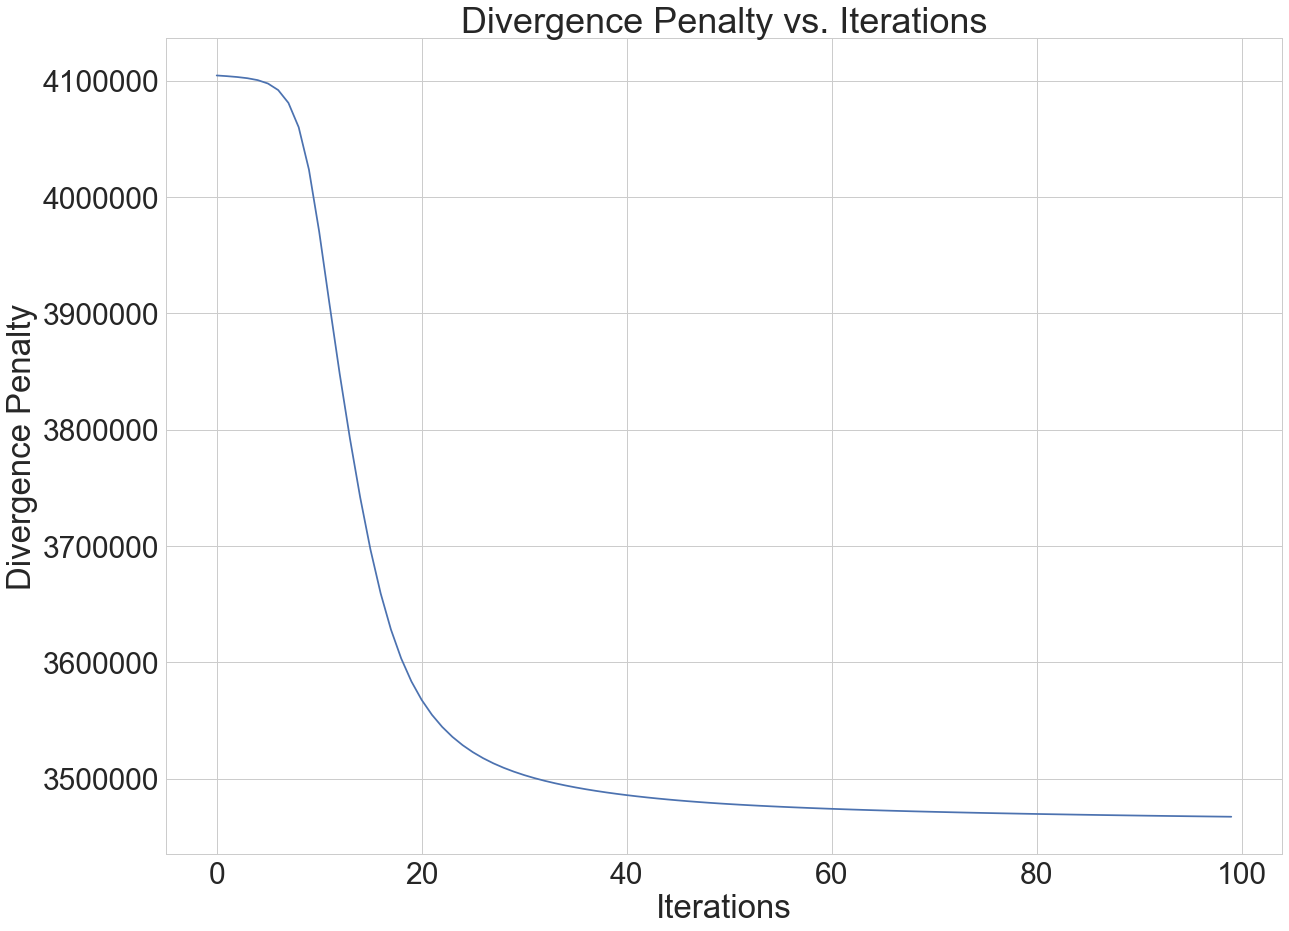

----------------------------------------------------------------------------------------------------------------------------------
   percent - 0.020147    |   building - 0.025666   |     book - 0.034010     |    editor - 0.019755    |     art - 0.016461      
   company - 0.019687    |     city - 0.016718     |    write - 0.025814     |   question - 0.011061   |    artist - 0.012388    
    market - 0.018898    |    house - 0.016163     |    story - 0.015746     |    public - 0.009864    |    design - 0.011338    
    price - 0.015805     |    street - 0.011412    |     life - 0.015626     |   article - 0.008947    |    museum - 0.010777    
    stock - 0.013173     |     park - 0.011341     |     page - 0.012079     |    issue - 0.007634     |    color - 0.010685     
    share - 0.012346     |    build - 0.010753     |    author - 0.011715    |     view - 0.007276     |  collection - 0.010021  
     sell - 0.011744     |     open - 0.010368     |   publish - 0.011434    |    point -

In [190]:
if __name__ == '__main__':
    #test_part_1()
    test_part_2()
    